In [ ]:
################################
##### Library Installation #####
################################

In [1]:
# Uncomment last row when the script runs for the first time 
# install newsapi
#!pip install newsapi-python

In [2]:
# Uncomment last row when the script runs for the first time 
# install yfinance
#!pip install yfinance

In [ ]:
##########################
##### Import Library #####
##########################

In [1]:
# import nlp module
import nltk
# install vader for sentiment analysis
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# import visualization module
import matplotlib.pyplot as plt
import seaborn as sns
# set figure size
plt.rcParams["figure.figsize"] = (13,8)

# import data processing module
import numpy as np
import pandas as pd
# show full output for dataframe
pd.set_option('display.max_colwidth',1000)

# import newsapi to collect news headlines and description
from newsapi import NewsApiClient
from datetime import date, timedelta, datetime

# import yfinance to download stock price
import yfinance as yf

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/spy1106/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
###############################################################################
##### Get API from website https://newsapi.org/ if run for the first time #####
###############################################################################

In [ ]:
########################
########################
##### Type in here #####
########################
########################

In [24]:
# Define API
NEWS_API_KEY = '10c97c512cf34a81b101130fface332d'
#NEWS_API_KEY = '264bee2d6a934d66bf3a8e5f6e5f06a8'

In [ ]:
##############################
##### Define news source #####
##############################

In [3]:
# Function to get news from specific source
def get_sources(category = None):
    
    # call api
    newsapi = NewsApiClient(api_key = NEWS_API_KEY)
    
    # call get sources function
    sources = newsapi.get_sources()
    
    # get news source
    if category is not None:
        rez = [source['id'] for source in sources['sources'] if source['category'] == category and source['language'] == 'en']
    else:
        rez = [source['id'] for source in sources['sources'] if source['language'] == 'en']
  
    return rez

In [4]:
# Original number of news source if without define category
len(get_sources())

81

In [5]:
# Let's try only getting business news source
print('Number of news source in business category:', len(get_sources('business')))
print('And they are:', get_sources('business'))

Number of news source in business category: 7
And they are: ['australian-financial-review', 'bloomberg', 'business-insider', 'business-insider-uk', 'financial-post', 'fortune', 'the-wall-street-journal']


In [ ]:
##############################################
##### Get news description and sentiment #####
##############################################

In [9]:
# Function to get news title, description, sentiment and url
def get_articles_sentiments(keywrd, startd, sources_list = None, show_all_articles = False):
    
    # call api
    newsapi = NewsApiClient(api_key = NEWS_API_KEY)
    
    # Make sure start day in datetime format
    if type(startd) == str:
        my_date = datetime.strptime(startd,'%d-%b-%Y')
    else:
        my_date = startd
  
    if sources_list:
        articles = newsapi.get_everything(q = keywrd, #stock name
                                          from_param = my_date.isoformat(), #start date, format e.g. 2022-04-18
                                          to = (my_date + timedelta(days = 1)).isoformat(), #end date, format e.g. 2022-04-18
                                          language="en", #English article
                                          sources = ",".join(sources_list), #define news source if any (try which source more accountable)
                                          sort_by="relevancy", #get the most relevant articles in front
                                          page_size = 100) #only get top 100 pages news
    else:
        articles = newsapi.get_everything(q = keywrd,
                                          from_param = my_date.isoformat(), 
                                          to = (my_date + timedelta(days = 1)).isoformat(),
                                          language="en",
                                          sort_by="relevancy",
                                          page_size = 100)
    
    # Store article titles to check if has been processed or not
    seen = set()
    # Store article title and description for sentiment analysis
    article_content = ''
    # Store details as list to form dataframe
    date_sentiments_list = []
  
    for article in articles['articles']:
        # Check if the the same article has been processed
        if str(article['title']) in seen:
            continue
        else:
            seen.add(str(article['title'])) #store article title for if-clause checking
            article_content = str(article['title']) + '. ' + str(article['description']) #store title and description for sentiment analysis
            sentiment = sia.polarity_scores(article_content)['compound'] #only take the compound value for evaluation
            date_sentiments_list.append((my_date,article['title'],article['description'],sentiment, article['url']))
    
    # Return dataframe with 5 columns sorted by positive as 1st row
    return pd.DataFrame(date_sentiments_list, columns=['Date', 'Title','Description','Sentiment','URL']).sort_values(by='Sentiment', ascending=False).reset_index(drop=True)

In [ ]:
###################################################
##### Test if all/business news source to use #####
###################################################

In [6]:
# Function to compute sentiment from all and only business news sources and return dataframe with date, sentiments and close price
#Reminder: FREE NewsAPI allows to retrieve only 1 month of news data
#Reminder: Limited to 100 requests over a 24 hour period

def sent_vs_price(start_date, end_date, keywrd, stock):
    # Define current day as a variable for while loop use
    current_day = start_date
    # List to store mean sentiment given all news source
    sentiment_all_score = []
    # List to store mean sentiment given only business news source
    sentiment_business_score = []
    # List to store the dates from start to today
    dates = []

    # Starting from the first date
    while current_day <= end_date:
    
        # Store the date into the list
        dates.append(current_day)
    
        # Get news title, description, sentiment and url from all news source
        sentiments_all = get_articles_sentiments(keywrd = keywrd, startd = current_day, sources_list = None, show_all_articles= True)
        # Store mean sentiment given all news source
        sentiment_all_score.append(sentiments_all.Sentiment.mean())
    
        # Get news title, description, sentiment and url from only business news source
        sentiments_business = get_articles_sentiments(keywrd = keywrd, startd = current_day, sources_list = get_sources('business'), show_all_articles= True)
        # Store mean sentiment given only business news source
        sentiment_business_score.append(sentiments_business.Sentiment.mean())
    
        # Add one day to current day
        current_day = current_day + timedelta(days=1)
        
    # Create dataframe with date as index and sentiment mean from all and business news sources
    sentiments = pd.DataFrame(list(zip(sentiment_all_score, sentiment_business_score)), index = pd.DatetimeIndex(dates), columns =['All_sources_sentiment','Business_sources_sentiment'])
    # Set index name as Date
    sentiments.index.name = 'Date'
    # Download stock price data from yfinance and join close price with the above dataframe
    sentiments_vs_price = sentiments.join(yf.download(stock, start = start_date, end = end_date)['Close']).dropna()
        
    # Return the dataframe for plotting
    return sentiments_vs_price

In [ ]:
########################
########################
##### Type in here #####
########################
########################

In [29]:
# Define end date as today
end_date = date.today()
# Starting date would be of the day one month prior to today
start_date = date(year = end_date.year, month = end_date.month-1, day = end_date.day)
# keywrd for api searching
keywrd = 'Tesla stock'
# stock for yfinance to download price
stock = 'TSLA'

print('Start day:', start_date)
print('End day:', end_date)
print('API keyword:', keywrd)
print('Stock Price of:', stock)

Start day: 2022-03-26
End day: 2022-04-26
API keyword: Tesla stock
Stock Price of: TSLA


In [30]:
sentiments_vs_price = sent_vs_price(start_date, end_date, keywrd, stock)
sentiments_vs_price

NewsAPIException: {'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}

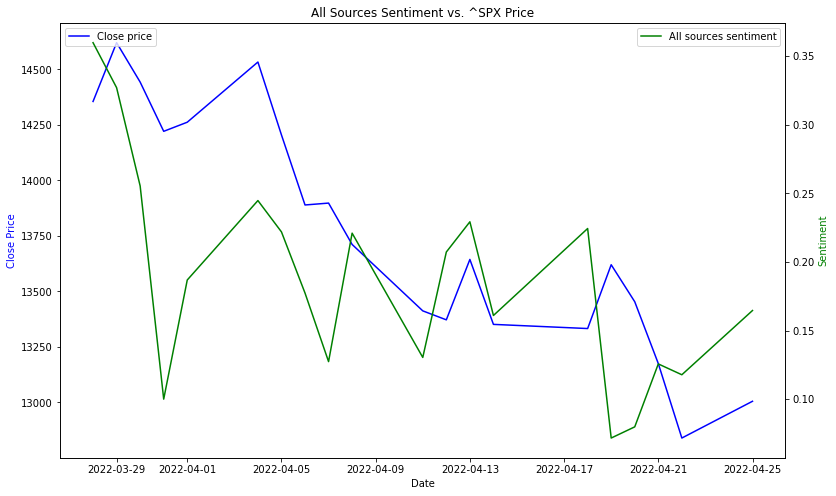

In [22]:
# Plot All Sources Sentiment vs. Price 
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(sentiments_vs_price.index,sentiments_vs_price['Close'], color="b",label='Close price')
ax2.plot(sentiments_vs_price.index,sentiments_vs_price['All_sources_sentiment'], color="g",label='All sources sentiment')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
title = 'All Sources Sentiment vs. ' + stock + ' Price'
ax1.set_title(title)
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color="b")
ax2.set_ylabel('Sentiment', color="g")
image_title = title + '.png'
plt.savefig(image_title, bbox_inches='tight')
plt.show()

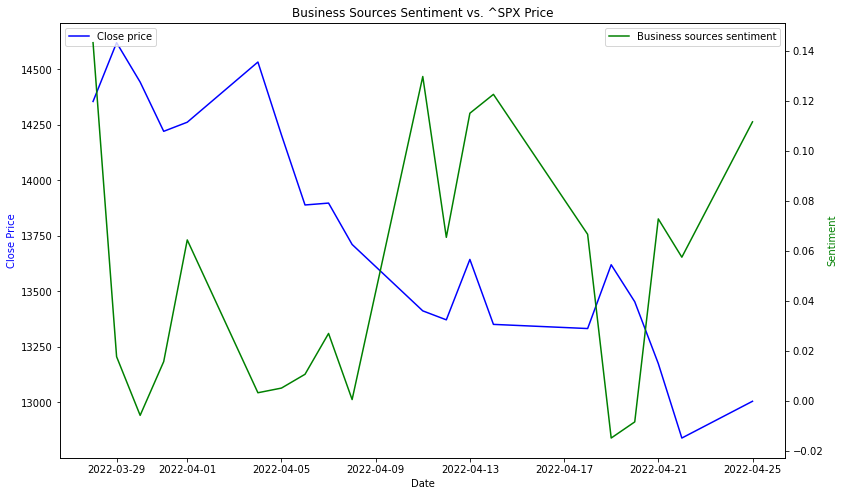

In [23]:
# Plot Business Sources Sentiment vs. Price 
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(sentiments_vs_price.index,sentiments_vs_price['Close'], color="b",label='Close price')
ax2.plot(sentiments_vs_price.index,sentiments_vs_price['Business_sources_sentiment'], color="g",label='Business sources sentiment')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
title = 'Business Sources Sentiment vs. ' + stock + ' Price'
ax1.set_title(title)
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color="b")
ax2.set_ylabel('Sentiment', color="g")
image_title = title + '.png'
plt.savefig(image_title, bbox_inches='tight')
plt.show()